In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
import tensorboard
tensorboard.__version__
# Clear any logs from previous runs
!rm -rf ./logs/ 

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
import math
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TensorFlow version:  2.6.0
/kaggle/input/dcnv2-softmaxclassification/pseudolabels_v5.csv
/kaggle/input/dcnv2-softmaxclassification/__results__.html
/kaggle/input/dcnv2-softmaxclassification/pseudolabels_v0.csv
/kaggle/input/dcnv2-softmaxclassification/matrix_resurrections.pq
/kaggle/input/dcnv2-softmaxclassification/submission.csv
/kaggle/input/dcnv2-softmaxclassification/__notebook__.ipynb
/kaggle/input/dcnv2-softmaxclassification/submission_00.csv
/kaggle/input/dcnv2-softmaxclassification/__output__.json
/kaggle/input/dcnv2-softmaxclassification/custom.css
/kaggle/input/dcnv2-softmaxclassification/__results___files/__results___79_6.png
/kaggle/input/dcnv2-softmaxclassification/__results___files/__results___79_14.png
/kaggle/input/dcnv2-softmaxclassification/__results___files/__results___79_9.png
/kaggle/input/dcnv2-softmaxclassification/__results___files/__results___79_15.png
/kaggle/input/dcnv2-softmaxclassification/__results___files/__results___109_0.png
/kaggle/input/dcnv2-softmax

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = True # True: For submission run. False: Fast trial run

# Hyperparameters
FOLDS = 20 if PRODUCTION else 5   # Only 5 or 10.
EPOCHS = 68        # Does not matter with Early stopping. Deep network should not take too much epochs to learn
BATCH_SIZE = 2048   # large enough to fit RAM. If unstable, tuned downward. 4096 2048
ACTIVATION = 'swish' # swish mish relu selu ;swish overfit more cause of narrow global minimun
KERNEL_INIT = "glorot_normal" # Minimal impact, but give your init the right foot forward glorot_uniform lecun_normal
LEARNING_RATE = 0.000965713 # Not used. Optimal lr is about half the maximum lr 
LR_FACTOR = 0.5   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau. lower down when the LR oscillate
MIN_DELTA = 0.0000001 # Default 0.0001 0.0000001
RLRP_PATIENCE = 5 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 16  # Early stopping
DROPOUT = 0.05     # Act like L1 L2 regulator. lower your learning rate in order to overcome the "boost" that the dropout probability gives to the learning rate.
HIDDEN_LAYERS = [320, 288, 64, 32]

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy does not require onehot encoding on labels. categorical_crossentropy
METRICS ='accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 2262087 if PRODUCTION else 11426   # True for FULL run. Max Sample size per category. For quick test: y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3           # speed trial any% Not used here
MI_THRESHOLD = 0.001    # Mutual Information threshold value to drop.

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id"            # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"
TPU = False           # True: use TPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = True
BLEND = True

assert BATCH_SIZE % 2 == 0, \
    "BATCH_SIZE must be even number."

In [3]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [4]:
# for col in df.select_dtypes('int').columns:
#     df[col] = pd.to_numeric(df[col], downcast = 'integer')

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [5]:
from category_encoders import MEstimateEncoder
# extra feature engineering


def feature_engineer(df):

    # Distance features
    # Euclidean distance to Hydrology
    df["ecldn_dist_hydrlgy"] = (
        df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    df["fire_road"] = np.abs(df["Horizontal_Distance_To_Fire_Points"]) + \
        np.abs(df["Horizontal_Distance_To_Roadways"])

    # Elevation features
    df['highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)

    # Aspect features, hardest FE
    df.loc[df["Aspect"] < 0, "Aspect"] += 360
    df.loc[df["Aspect"] > 359, "Aspect"] -= 360
    df['binned_aspect'] = [math.floor((v+60)/15.0) for v in df['Aspect']]
    df['binned_aspect2'] = [math.floor((v+180)/10.0) for v in df['Aspect']]

    # Soil and wilderness features
    soil_features = [x for x in df.columns if x.startswith("Soil_Type")]
    df["soil_type_count"] = df[soil_features].sum(axis=1)
    wilderness_features = [
        x for x in df.columns if x.startswith("Wilderness_Area")]
    df["wilderness_area_count"] = df[wilderness_features].sum(axis=1)
    df['soil_Type12_32'] = df['Soil_Type32'] + df['Soil_Type12']
    df['soil_Type23_22_32_33'] = df['Soil_Type23'] + \
        df['Soil_Type22'] + df['Soil_Type32'] + df['Soil_Type33']

    # Hillshade features
    features_Hillshade = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    df['Hillshade_Noon_is_bright'] = (df.Hillshade_Noon == 255).astype(int)
    df['Hillshade_9am_is_zero'] = (df.Hillshade_9am == 0).astype(int)
    df['hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)

    df.drop(["Aspect", 'Horizontal_Distance_To_Hydrology'], axis=1, inplace=True)

    return df


In [6]:
from pathlib import Path


def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    column_y = df_train.columns.difference(
        df_test.columns)[0]  # column_y target_col label_col
    return df_train, df_test, column_y


In [7]:
def process_data(df_train, df_test):
    # Preprocessing
    df_train = impute(df_train)
    df_test = impute(df_test)
    
    if FEATURE_ENGINEERING:
        df_train = feature_engineer(df_train)
        df_test = feature_engineer(df_test)
    
    df_train = reduce_mem_usage(df_train)
    df_test = reduce_mem_usage(df_test)

    return df_train, df_test

In [8]:
%%time
train_data, test_data, column_y = load_data()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 11.7 s, sys: 1.86 s, total: 13.6 s
Wall time: 20.3 s


In [9]:
if PSEUDO_LABEL:
    df_pseudolabels = pd.read_csv(
        "../input/dcnv2-softmaxclassification/pseudolabels_v0.csv", index_col=ID)
    df_pseudolabels.to_csv(
        "pseudolabels_v0.csv", index=True)
    #idx = train_data[train_data[column_y] == 1].index
    #train_data.drop(idx, axis = 0, inplace = True)
    #idx = train_data[train_data[column_y] == 2].index
    #train_data.drop(idx, axis = 0, inplace = True)
    # join blending club for new baseline
    train_data = pd.concat([train_data, df_pseudolabels], axis=0)

In [10]:
%%time
train_data, test_data = process_data(train_data, test_data)

Mem. usage decreased to 400.54 Mb (84.1% reduction)
Mem. usage decreased to 79.15 Mb (84.0% reduction)
CPU times: user 32.8 s, sys: 19.6 s, total: 52.4 s
Wall time: 52.3 s


In [11]:
# customized XY TBR
idx = train_data[train_data[column_y] == 4].index
train_data.drop(idx, axis = 0, inplace = True)
idx = train_data[train_data[column_y] == 5].index
train_data.drop(idx, axis = 0, inplace = True)
# idx = train_data[train_data[column_y] == 6].index # Less then 0.5% significant different, dropped
# train_data.drop(idx, axis = 0, inplace = True)

cols = ["Soil_Type7", "Soil_Type15"]
train_data.drop(cols, axis = 1, inplace= True)
test_data.drop(cols, axis = 1, inplace = True)

In [12]:
X = train_data.drop(columns=column_y)
y = train_data[[column_y]].astype(int)

X_test = test_data.loc[:,X.columns]

gc.collect()

46

In [14]:
# Uncomment to peek at samples across all targets.
small_sampling = train_data.groupby(column_y).apply(lambda s: s.sample(min(len(s), 3900)))

In [15]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, random_state=0):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.rcParams["figure.figsize"] = (15,12)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [16]:
def drop_uninformative(df, mi_scores, threshold = 0.001):
    return df.loc[:, mi_scores > threshold]

In [17]:
def plot_features(features, df):
    for feature in features:
        plt.rcParams["figure.figsize"] = (15,9)
        for ctype in list(df[column_y].unique()):
            values = df.loc[df[column_y] == ctype][feature].values
            sns.scatterplot(x=values, y=np.arange(values.size), label=f"{column_y} {ctype}", alpha=0.35, palette="deep")
        plt.title(feature)
        plt.legend()
        plt.show()

In [25]:
def sampling_size_params(labels, sampling_max_size = SAMPLE):
    ''' Return sampling parameters {labels: sample_size}'''
    sampling_key, sampling_count = np.unique(labels, return_counts=True)
    sampling_count[sampling_count > sampling_max_size] = sampling_max_size
    zip_iterator = zip(sampling_key, sampling_count)
    return dict(zip_iterator)

In [26]:
# not minority
sampling_params = sampling_size_params(y, SAMPLE)
undersample = RandomUnderSampler(
    sampling_strategy=sampling_params, random_state=RANDOM_STATE)

X, y = undersample.fit_resample(X, y)

In [28]:
soil_features = [x for x in X.columns if x.startswith("Soil_Type")]
wilderness_features = [x for x in X.columns if x.startswith("Wilderness_Area")]
binary_features = soil_features + wilderness_features

In [29]:
transform_cols = X.columns[~X.columns.isin(binary_features)] # Numeric features

In [30]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y_cat = le.fit_transform(y[column_y]) # y to categorical

In [32]:
CSV_HEADER = list(train_data.columns[:])

TARGET_FEATURE_NAME = column_y

TARGET_FEATURE_LABELS = np.unique(y_cat)

NUMERIC_FEATURE_NAMES = list(X.columns[:])

CATEGORICAL_FEATURES_WITH_VOCABULARY = {}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

INPUT_SHAPE = X.shape[-1]
OUTPUT_SHAPE = le.classes_.shape[-1]

In [33]:
print(CSV_HEADER)
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

['Elevation', 'Slope', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type', 'ecldn_dist_hydrlgy', 'fire_road', 'highwater', 'binned_aspect', 'binned_aspect2', 'soil_type_count', 'wilderness_area_count', 'soil_Type12_32', 'soil_Type23_22_3

In [34]:
del mi_scores
del small_sampling
del df_pseudolabels
# del df_sampling_pseudolabels
del train_data
gc.collect()

20427

In [35]:
transformer_cat_cols = make_pipeline(
    SimpleImputer(),
)
transformer_num_cols = make_pipeline(
    RobustScaler(),
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_num_cols, transform_cols), # X.columns[:] transform_cols remainder = 'passthrough'
    ('passthrough', binary_features)
)

In [36]:
X["mean"] = X[transform_cols].mean(axis=1)
X["std"] = X[transform_cols].std(axis=1)
X["min"] = X[transform_cols].min(axis=1)
X["max"] = X[transform_cols].max(axis=1)
X["skew"] = X[transform_cols].skew(axis=1)

X_test["mean"] = X_test[transform_cols].mean(axis=1)
X_test["std"] = X_test[transform_cols].std(axis=1)
X_test["min"] = X_test[transform_cols].min(axis=1)
X_test["max"] = X_test[transform_cols].max(axis=1)
X_test["skew"] = X_test[transform_cols].skew(axis=1)

In [37]:
X_train_transformed = preprocessor.fit_transform(X)
X_test_transformed = preprocessor.transform(X_test)

In [38]:
modelCheckpoint = None

if TPU:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    modelCheckpoint = ModelCheckpoint(  'best_model.pb', options = save_locally,
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )
else:
    modelCheckpoint = ModelCheckpoint(
                                        'best_model',
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )

early_stopping = EarlyStopping(
        patience = ES_PATIENCE,
        min_delta = MIN_DELTA,
        monitor = ACC_VAL_METRICS,
        mode = 'max',
        restore_best_weights = True,       
        baseline = None,
        verbose = VERBOSE,
    )
plateau = ReduceLROnPlateau(
        patience = RLRP_PATIENCE,
        factor = LR_FACTOR,
        min_lr = 1e-7,
        monitor = 'val_loss', 
        mode = 'min',
        verbose = VERBOSE,
    )

def get_MLPmodel(**kwargs):
# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"
    model = keras.Sequential([
#     layers.BatchNormalization(input_shape = [X.shape[-1]], name = 'input'),
    layers.Dense(units = 300, input_shape = [INPUT_SHAPE], name = 'input', kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 200, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 100, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 50, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output'), #y_cat.shape[-1]
    ])

    return model

In [39]:
class MCDropout(keras.layers.AlphaDropout):
    '''Boost the performance of any trained dropout model without having to retrain it or even modify it at all.
        Provide a much better measure of the models uncertainty'''
    def call(self, inputs):
        return super().call(inputs, training=True)

class Standardization(layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis = 0, keepdims = True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims = True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
    
# create custom dense-block
class DenseBlock(layers.Layer):
    def __init__(self, units, activation = ACTIVATION, dropout_rate = 0, l2 = 0, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.dense = layers.Dense(
            units = units, 
#             activation = activation,
            kernel_initializer = KERNEL_INIT, 
#             kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
        if dropout_rate > 0:
            self.dropout = layers.Dropout(rate = dropout_rate) #MCDropout layers.Dropout
        else:
            self.dropout = None
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation(x)
        x = self.batchn(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x

# create fully-connected NN
class MLP(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.hidden_layers = [DenseBlock(units = units,
                                         activation = activation,
                                         dropout_rate = dropout_rate,
                                         l2 = l2
                                        )
                              for units in hidden_layers
                             ]
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        x = inputs
        for dense_layer in self.hidden_layers:
            x = dense_layer(x)
        x = self.softmax(x)
        return x

In [40]:
# create dense & cross model
class CrossNet(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(CrossNet, self).__init__(**kwargs)

        for i, units in enumerate(hidden_layers, start=1):
            if i == 1: # Dropout before last layer only len(hidden_layers)
                self.dense_layers = [DenseBlock(units = units, activation = activation, dropout_rate = dropout_rate, l2 = l2)]
            else:
                self.dense_layers.append(DenseBlock(units = units, activation = activation, dropout_rate = 0, l2 = l2))
        
        self.dense = layers.Dense(units = INPUT_SHAPE)
        self.concat = layers.Concatenate()
        self.batchn = layers.BatchNormalization()
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        
        dense, cross = inputs, inputs
        
        for dense_layer in self.dense_layers:
            # Deep net TODO only dropout at last layer
            dense = dense_layer(dense)
            # Parrallel Cross net
            cross_current = self.dense(cross)
            cross = inputs * cross_current + cross
            
        cross = self.batchn(cross)
        
        merged = self.concat([dense, cross])
        return self.softmax(merged)

In [41]:
def wide_deep_model(**kwargs):
    il = layers.Input(shape=(INPUT_SHAPE), name="input")
    x1 = layers.Dense(units=100, activation=ACTIVATION)(il)
    x = layers.Dropout(DROPOUT)(x1)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=200, activation=ACTIVATION)(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.BatchNormalization()(x) #AlphaDropout
    x = layers.Dense(units=100, activation=ACTIVATION)(layers.Concatenate()([x, x1]))
    x = layers.Dropout(DROPOUT)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=50, activation=ACTIVATION)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(units=NUM_CLASSES, activation="softmax", name="output")(x)

    model = tf.keras.Model([il], output)
    return model

In [43]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [44]:
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [45]:
def create_deep_and_cross_model(hidden_units = HIDDEN_LAYERS, dropout_rate = DROPOUT):
    '''DCNv2 Model'''
    inputs = layers.Input(len(X.columns)) #create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [46]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)

class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelection, self).__init__(**kwargs)
        self.grns = list()
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs

In [47]:
def encode_vsn_inputs(inputs, encoding_size):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features

def create_grn_and_vsn_model(encoding_size, dropout_rate=DROPOUT):
    inputs = layers.Input(len(X.columns))
    feature_list = encode_vsn_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [49]:
kf = StratifiedKFold(
        n_splits=FOLDS, random_state=RANDOM_STATE, shuffle=True)

In [50]:
%%time

# Define the Keras TensorBoard callback.
#logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

ENCODING_SIZE = 96  # Encoding size for create_grn_and_vsn_model
strategy = None
if TPU:
    try:  # detect TPUs
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # TPU detection
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:  # detect GPUs
        # default strategy that works on CPU and single GPU
        strategy = tf.distribute.get_strategy()
        print("Number of accelerators: ", strategy.num_replicas_in_sync)
        # this is 8 on TPU v3-8, it is 1 on CPU and GPU
        BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# if TPU:        # instantiating the model in the strategy scope creates the model on the TPU
# resets
preds_valid_f = {}
preds_test = np.zeros((1, 1))  # [] init Soft voting
total_acc = []
f_scores = []
models = []

if TPU:
    with strategy.scope():
        load_locally = tf.saved_model.LoadOptions(experimental_io_device = '/job:localhost')
        best_model = tf.keras.models.load_model('../input/tps21dec-softmaxclassification/best_model.pb', options = load_locally) # loading in Tensorflow's "SavedModel" format
else:
    best_model = load_model('../input/tps21dec-softmaxclassification/best_model')
    
preds_test = preds_test + best_model.predict(X_test_transformed, batch_size = BATCH_SIZE)

for fold, (train_index, valid_index) in enumerate(kf.split(X=X, y=y[TARGET_FEATURE_NAME])):

    X_train, X_valid = X_train_transformed[train_index], X_train_transformed[valid_index]
    y_train, y_valid = y_cat[train_index], y_cat[valid_index]

    #   --------------------------------------------------------
    # Preprocessing
    index_valid = valid_index.tolist()

    #    --------------------------------------------------------
    #
    #  ----------------------------------------------------------
    # Model# instantiating the model in the strategy scope creates the model on the TPU
    if TPU:
        with strategy.scope():
            model = wide_deep_model(
                hidden_layers=HIDDEN_LAYERS,
                activation=ACTIVATION,
                dropout_rate=DROPOUT
            )
            model.compile(
                optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS],
            )

    else:  # CPU/GPU model = create_grn_and_vsn_model(encoding_size=ENCODING_SIZE) CrossNet wide_deep_model
        model = CrossNet(
            hidden_layers=HIDDEN_LAYERS,
            activation=ACTIVATION,
            dropout_rate=DROPOUT
        )
        model.compile(
            optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS],
        )

    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=[early_stopping, plateau, modelCheckpoint,  # tensorboard_callback
                                   ],
                        shuffle=True,
                        verbose=VERBOSE,
                        )

    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid, batch_size=BATCH_SIZE)

    #  ----------------------------------------------------------
    #********  test dataset predictions for submission *********#
    if not BEST_OR_FOLD:
        preds_test = preds_test + \
            model.predict(X_test_transformed, batch_size=BATCH_SIZE)

    #  ----------------------------------------------------------
    #  Saving scores to plot the end
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    if fold == 0:
        f_scores = scores
        model.summary()
#         keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
    else:
        f_scores = pd.concat([f_scores, scores], axis=0)

    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(
        dict(zip(index_valid, le.inverse_transform(np.argmax(preds_valid, axis=1)))))
    # Getting score for a fold model
    fold_acc = accuracy_score(y.iloc[valid_index].Cover_Type, le.inverse_transform(
        np.argmax(preds_valid, axis=1)))
    print(
        f"Fold {fold} accuracy_score: {fold_acc} Train: {X_train.shape} Valid: {X_valid.shape}")
    # Total acc
    total_acc.append(fold_acc)

    del model
    gc.collect()
    K.clear_session()

print(f"mean accuracy_score: {np.mean(total_acc)}, std: {np.std(total_acc)}")


2022-12-02 01:33:26.496978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 01:33:26.647259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 01:33:26.648084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 01:33:26.649976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "cross_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_block (DenseBlock)     multiple                  21440     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  93600     
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  18752     
_________________________________________________________________
dense_block_3 (DenseBlock)   multiple                  2208      
_________________________________________________________________
dense_4 (Dense)              multiple                  3906      
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
batch_normalization_4 (Batch multiple                  24

2022-12-02 01:38:38.673315: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1056997576 exceeds 10% of free system memory.
2022-12-02 01:38:39.826387: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1056997576 exceeds 10% of free system memory.


Fold 1 accuracy_score: 0.9661021482607514 Train: (4262087, 62) Valid: (224321, 62)


2022-12-02 01:45:24.511607: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1056997576 exceeds 10% of free system memory.


Fold 2 accuracy_score: 0.9646577895070011 Train: (4262087, 62) Valid: (224321, 62)
Fold 3 accuracy_score: 0.9645106788931932 Train: (4262087, 62) Valid: (224321, 62)
Fold 4 accuracy_score: 0.9644883894062527 Train: (4262087, 62) Valid: (224321, 62)
Fold 5 accuracy_score: 0.9639356101301261 Train: (4262087, 62) Valid: (224321, 62)
Fold 6 accuracy_score: 0.963293672906237 Train: (4262087, 62) Valid: (224321, 62)
Fold 7 accuracy_score: 0.96378404161893 Train: (4262087, 62) Valid: (224321, 62)
Fold 8 accuracy_score: 0.9642162981455065 Train: (4262088, 62) Valid: (224320, 62)
Fold 9 accuracy_score: 0.9642385877318117 Train: (4262088, 62) Valid: (224320, 62)
Fold 10 accuracy_score: 0.9636011055634808 Train: (4262088, 62) Valid: (224320, 62)
Fold 11 accuracy_score: 0.9651702924393724 Train: (4262088, 62) Valid: (224320, 62)
Fold 12 accuracy_score: 0.966182239657632 Train: (4262088, 62) Valid: (224320, 62)
Fold 13 accuracy_score: 0.9653396932952925 Train: (4262088, 62) Valid: (224320, 62)
Fold

In [51]:
# Load best_model
if BEST_OR_FOLD:
    if not TPU:
        # load the saved model
        best_model = load_model('best_model')
    else: # TPU
        with strategy.scope():
            load_locally = tf.saved_model.LoadOptions(experimental_io_device = '/job:localhost')
            best_model = tf.keras.models.load_model('best_model', options = load_locally) # loading in Tensorflow's "SavedModel" format
    # Using best model to predict
    # X_test = preprocessor.transform(X_test) Not using best loop fit TODO
    preds_test = preds_test + best_model.predict(X_test_transformed, batch_size = BATCH_SIZE)

# Evaluation

In [55]:
oof_y_hat = []
for key, value in sorted(preds_valid_f.items()):
    oof_y_hat.append(value)

# Submission

In [59]:
sub = pd.read_csv(INPUT + '/sample_submission.csv')
sub[column_y] = le.inverse_transform(
    np.argmax(preds_test, axis=1)).astype(int)
sub.to_csv('submission.csv', index=False)
sub

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
...,...,...
999995,4999995,2
999996,4999996,1
999997,4999997,2
999998,4999998,1


## Bootstrap blending

In [60]:
col_names = [f'{clss}' for clss in le.classes_]
if PRODUCTION:
    pd.DataFrame(preds_test, columns=col_names).to_parquet('matrix_resurrections.pq')

In [61]:
np.unique(sub[column_y], return_counts=True)

(array([1, 2, 3, 6, 7]), array([388493, 510936,  78689,   5980,  15902]))

In [62]:
np.unique(y_cat, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1855196, 2262087,  273664,   17398,   78063]))

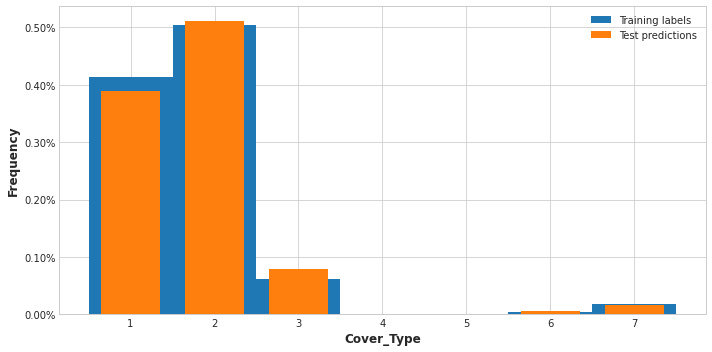

In [63]:
# Plot the distribution of the test predictions vs training set
plt.figure(figsize=(10,5))
plt.hist(y[column_y], bins = np.linspace(0.5, 7.5, 8), density = True, label = 'Training labels')
plt.hist(sub[column_y], bins = np.linspace(0.5, 7.5, 8), density = True, rwidth = 0.7, label = 'Test predictions')
plt.xlabel(column_y)
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.show()


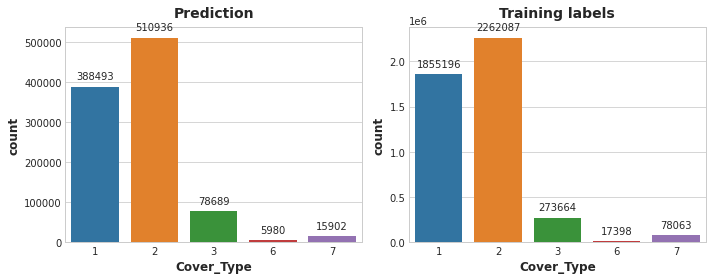

In [64]:
def plot_x_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

# Plot the distribution of the test predictions
fig, ax = plt.subplots(1,2,figsize = (10,4))
sns.countplot(x = sub[column_y], ax = ax[0], orient = "h").set_title("Prediction")
plot_x_labels(ax[0])
# Plot the distribution of the training set
sns.countplot(x = y[column_y], ax = ax[1], orient = "h").set_title("Training labels")
plot_x_labels(ax[1])
fig.show()

## Prediction visualized

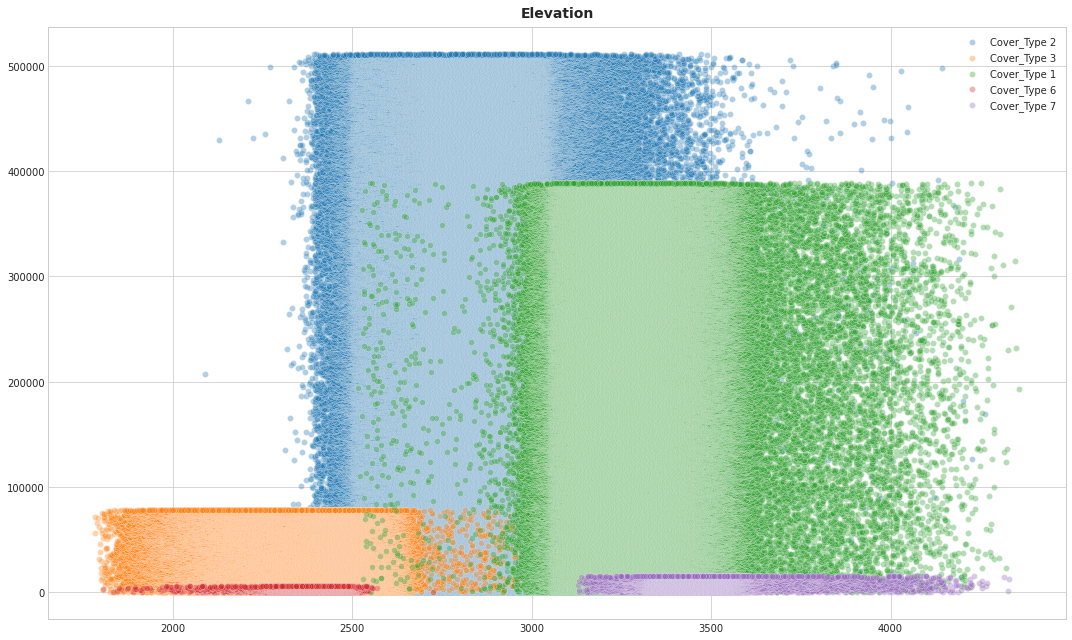

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


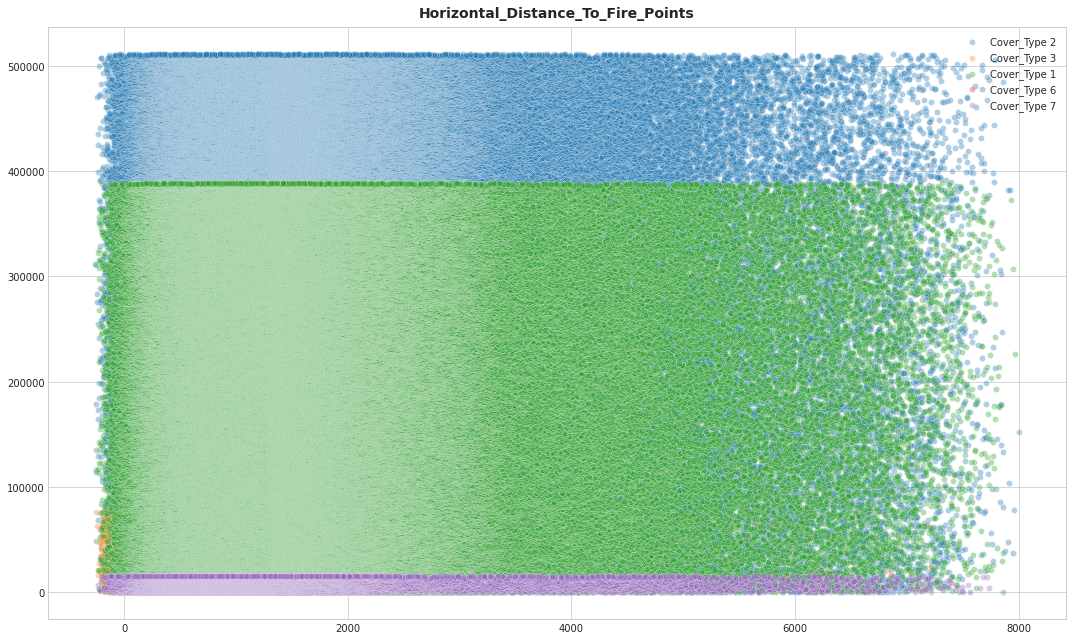

In [65]:
data_dir = Path(INPUT)
df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
df_test.reset_index(drop=True, inplace=True)
df_test[column_y] = sub[column_y]

plot_features(features=features_cols,df=df_test)

## New pseudolabels

In [66]:
new_index = np.arange(4000000, 4999999 + 1)
df_test[ID] = new_index
df_test.set_index(ID, inplace=True)
df_test.to_csv('pseudolabels_v5.csv', index=True)

To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/tabular-playground-series-dec-2021/code) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

## Op-level graph

Start TensorBoard and wait a few seconds for the UI to load. Select the Graphs dashboard by tapping “Graphs” at the top. 

In [67]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard
# %tensorboard --logdir logs

In [68]:
# %reload_ext tensorboard